In [1]:
import torch
from torch import nn
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import requests
import os
import logging


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
logging.info(f"Using {device}")


In [3]:
class Util:
    def __init__(self):
        pass

    def lhs(self, n_samples: int, n_dims: int, dtype=torch.float64, show_plot: bool = False):
        spaces = torch.linspace(0, 1, n_samples + 1, dtype=dtype).to(device)

        # We need to unsqueeze so that we can use broadcasting on the n_dims
        lower_bound = spaces[:-1].unsqueeze(1)
        upper_bound = spaces[1:].unsqueeze(1)

        rand_idx = torch.rand(n_samples, n_dims, device=device)
        points = lower_bound + rand_idx * (upper_bound - lower_bound)

        if show_plot:
            self.print_2d_space(points)

        for i in range(n_dims):
            samples_idx = torch.randperm(n_samples, device=device)
            points[:,i] = points[samples_idx,i]

        if show_plot:
            self.print_2d_space(points)

        return points

    def print_2d_space(self, X):
        plt.scatter(X[:, 0].numpy(), X[:, 1].numpy(), color='blue', s=50)
        plt.show()



In [4]:
class WaveRawData:
    def __init__(self):
        x = np.linspace(0, 1, 1000)
        t = np.linspace(0, 1, 2000)

        T, X = np.meshgrid(t, x)

        u = np.sin(np.pi * X) * np.cos(10 * np.pi * T) + np.sin(2 * np.pi * X) * np.cos(20 * np.pi * T)

        self.X = X
        self.T = T
        self.u = u

In [5]:
wave_raw_data = WaveRawData()

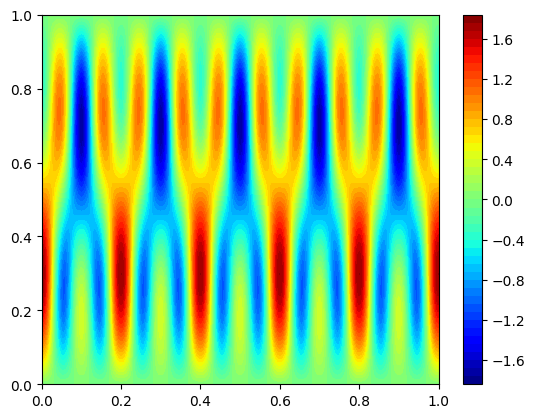

In [6]:
plt.contourf(wave_raw_data.T, wave_raw_data.X, wave_raw_data.u, levels=50, cmap="jet")
plt.colorbar()

In [7]:
class Util:
    def __init__(self):
        pass

    def lhs(self, n_samples: int, n_dims: int, dtype=torch.float, show_plot: bool = False):
        spaces = torch.linspace(0, 1, n_samples + 1, dtype=dtype).to(device)

        # We need to unsqueeze so that we can use broadcasting on the n_dims
        lower_bound = spaces[:-1].unsqueeze(1)
        upper_bound = spaces[1:].unsqueeze(1)

        rand_idx = torch.rand(n_samples, n_dims, device=device)
        points = lower_bound + rand_idx * (upper_bound - lower_bound)

        if show_plot:
            self.print_2d_space(points)

        for i in range(n_dims):
            samples_idx = torch.randperm(n_samples, device=device)
            points[:,i] = points[samples_idx,i]

        if show_plot:
            self.print_2d_space(points)

        return points

    def print_2d_space(self, X):
        plt.scatter(X[:, 0].numpy(), X[:, 1].numpy(), color='blue', s=50)
        plt.show()

util = Util()

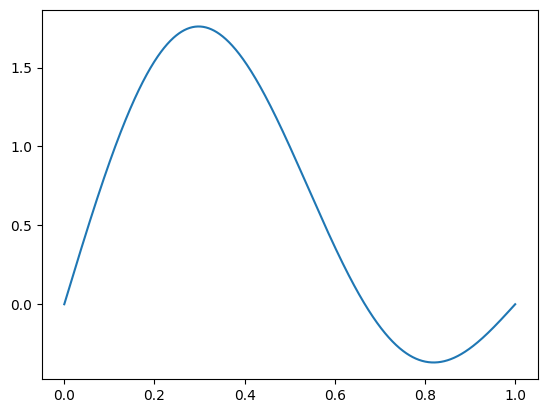

In [8]:
plt.plot(wave_raw_data.X[:,0], wave_raw_data.u[:,0])

In [9]:
class WaveData():
    def __init__(self, wave_raw_data: WaveRawData, n_data: int, n_boundary: int, n_collocation: int):
        x_bound = np.array([0, 1])
        t_bound = np.array([0, 1])

        all_x = torch.tensor(wave_raw_data.X[:,0], device=device, dtype=torch.float)

        rand_data_idx = torch.randint(0, all_x.shape[0], size=[n_data], device=device)

        x_data = all_x[rand_data_idx]
        x_data.requires_grad_(True)
        t_data = torch.zeros(size=(x_data.shape[0],), device=device, requires_grad=True)
        y_data = torch.tensor(wave_raw_data.u[:,0], device=device)

        t_boundary = torch.rand(size=(n_boundary,), device=device, requires_grad=True) * (t_bound[1] - t_bound[0]) + t_bound[0]
        x_low_boundary = torch.ones(t_boundary.shape[0], device=device, requires_grad=True) * x_bound[0]
        t_low_boundary = t_boundary.clone()
        t_low_boundary.requires_grad_(True)

        x_high_boundary = torch.ones(t_boundary.shape[0], device=device, requires_grad=True) * x_bound[1]
        t_high_boundary = t_boundary.clone()
        t_high_boundary.requires_grad_(True)

        x_ut_constraint = torch.rand(size=(n_boundary,), device=device, requires_grad=True) * (x_bound[1] - x_bound[0]) + x_bound[0]
        t_ut_constraint = torch.zeros(size=(x_ut_constraint.shape[0],), device=device, requires_grad=True)

        collocation_points = util.lhs(n_collocation, 2)
        x_collocation = x_bound[0] + collocation_points[:,0] * (x_bound[1] - x_bound[0])
        t_collocation = t_bound[0] + collocation_points[:,1] * (t_bound[1] - t_bound[0])

        x_collocation.requires_grad_(True)
        t_collocation.requires_grad_(True)


        self.x_data = x_data
        self.t_data = t_data
        self.y_data = y_data

        self.t_low_boundary = t_low_boundary
        self.x_low_boundary = x_low_boundary

        self.t_high_boundary = t_high_boundary
        self.x_high_boundary = x_high_boundary

        self.x_ut_constraint = x_ut_constraint
        self.t_ut_constraint = t_ut_constraint
        
        self.x_collocation = x_collocation
        self.t_collocation = t_collocation

In [10]:
class MLP(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(2, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 1)
        )

        self.apply(self._init_weights)

    def _init_weights(self, module):
        """Apply Xavier initialization to linear layers"""
        if isinstance(module, nn.Linear):
            # Xavier uniform initialization (also called Glorot uniform)
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)

    def forward(self, x, t):
        X = torch.stack([x, t], dim=1)
        return self.ff(X)

In [ ]:
wave_data = WaveData(wave_raw_data, 50, 50, 10000)

mlp = MLP()

optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

In [31]:
epochs = 200
for i in range(epochs):
    optimizer.zero_grad()
    for dt in [
        wave_data.x_collocation,
        wave_data.t_collocation,

        wave_data.x_data,
        wave_data.t_data,
        
        wave_data.x_low_boundary,
        wave_data.x_high_boundary,
        wave_data.t_low_boundary,
        wave_data.t_high_boundary,
        
        wave_data.t_ut_constraint,
        wave_data.x_ut_constraint
    ]:
        if dt.grad != None:
            dt.grad.zero_()

    
    # Data loss
    u_data = mlp(wave_data.x_data, wave_data.t_data)
    data_loss = torch.mean((u_data - wave_data.y_data)**2)
    
    # Boundary loss
    y_high_bound = mlp(wave_data.x_high_boundary, wave_data.t_high_boundary)
    y_low_bound = mlp(wave_data.x_low_boundary, wave_data.t_low_boundary)
    
    ut_boundary = mlp(wave_data.x_ut_constraint, wave_data.t_ut_constraint)
    u_t_boundary = torch.autograd.grad(
        torch.sum(ut_boundary),
        wave_data.t_ut_constraint,
        create_graph=True,
    )[0]
    
    boundary_loss = (
        torch.mean((y_high_bound - y_low_bound)**2) +
        torch.mean(u_t_boundary**2)
    )
    
    # PDE loss
    u_collocation = mlp(wave_data.x_collocation, wave_data.t_collocation)
    
    u_t = torch.autograd.grad(
        torch.sum(u_collocation),
        wave_data.t_collocation,
        create_graph=True,
        retain_graph=True
    )[0]

    u_tt = torch.autograd.grad(
        torch.sum(u_t),
        wave_data.t_collocation,
        create_graph=True
    )[0]
    
    u_x = torch.autograd.grad(
        torch.sum(u_collocation),
        wave_data.x_collocation,
        create_graph=True,
        retain_graph=True
    )[0]

    u_xx = torch.autograd.grad(
        torch.sum(u_x),
        wave_data.x_collocation,
        create_graph=True,
    )[0]
    
    f_u = u_tt - 100 * u_xx
    pde_loss = torch.mean(f_u**2)
    
    # Total loss
    loss = data_loss + pde_loss
    
    # Backpropagation
    loss.backward()

    optimizer.step()
    
    if i % 10 == 0:
        print(f"Epoch {i+1}, Loss = {loss.item():.6f}")


/var/folders/0t/07s2_q6s70l396_6l3y94msh0000gn/T/ipykernel_35831/2634273363.py:19: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/build/aten/src/ATen/core/TensorBody.h:494.)
  if dt.grad != None:


Epoch 1, Loss = 0.595809
Epoch 11, Loss = 0.595689
Epoch 21, Loss = 0.595617
Epoch 31, Loss = 0.595572
Epoch 41, Loss = 0.595543
Epoch 51, Loss = 0.595521
Epoch 61, Loss = 0.595504
Epoch 71, Loss = 0.595489
Epoch 81, Loss = 0.595475
Epoch 91, Loss = 0.595462
Epoch 101, Loss = 0.595449
Epoch 111, Loss = 0.595436
Epoch 121, Loss = 0.595423
Epoch 131, Loss = 0.595410
Epoch 141, Loss = 0.595398
Epoch 151, Loss = 0.595385
Epoch 161, Loss = 0.595372
Epoch 171, Loss = 0.595360
Epoch 181, Loss = 0.595347
Epoch 191, Loss = 0.595335


In [32]:
x, t = torch.tensor(wave_raw_data.X.reshape(-1), dtype=torch.float), torch.tensor(wave_raw_data.T.reshape(-1), dtype=torch.float)
y = mlp(x, t)

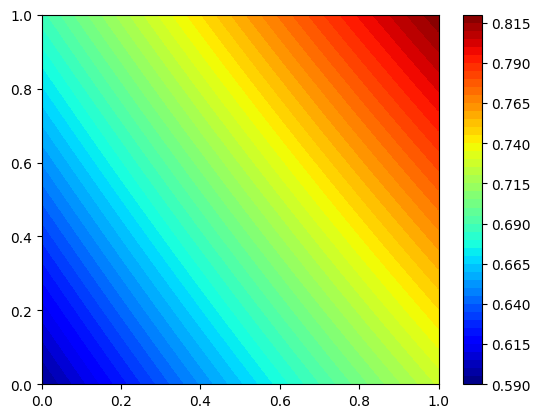

In [33]:
y_reshaped = y.reshape(wave_raw_data.u.shape[0], wave_raw_data.u.shape[1])

plt.contourf(wave_raw_data.T, wave_raw_data.X, y_reshaped.detach().cpu(), levels=50, cmap="jet")
plt.colorbar()